## What is the goal of this project?

#### The school world contains so much data and yet barely any schools are taking advantage of it.
#### Their administrators don't have the time to dig deep into the data and pull out information
#### This project will act almost as a POC to a potential plugin/dashboard that schools can enter into their Student Information Systems where administrators can quickly yield results that will help guide them to action

#### Some questions that we will be exploring: Can we predict the ELA (English Language Acquisition) status/level of a student based on their grade? What about their current english grade based on the previous 2 years of English test grades? Taking a mixed effect model and looking at differences. 
#### There are many more questions we can ask of the data, but for our current scope, we will focus on these 3.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.stats as stats
import pylab 
import math
%matplotlib inline

In [33]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
# Loading the data in long format (each respondent has one row per response)
data2=pd.read_csv('Report.csv')
#elaDummies = pd.get_dummies(data["ca_elastatus"])
#data = data.append(elaDummies)
print(data2.shape)
print(data2.columns)

(1478, 18)
Index(['student_number', 'grade_level', 'ca_elastatus', 'Race', 'Zip', 'E1',
       'E2', 'E3', 'M1', 'M2', 'M3', 'Days Attended', 'Days Absent 2018-2019',
       'Days Enrolled 2018-2019', 'Attendance Rate 2018-2019',
       'Absent Rate 2018-2019', 'Current English Grade', 'Current Math Grade'],
      dtype='object')


### Data cleanup and converting non-numerical fields to numeric

In [3]:
#I'm not exactly happy with this as we're essentially giving students 0 for missing data, but we have to start somewhere
#I might run another dataset dropping them and looking at the difference.
data2= data2.fillna(0)
#data= data.dropna(inplace=True)

In [4]:
#This is going to take our grades that are in letters and convert them to numbers
#We're not going to worry too much about the + and - even though they have a slight difference, we will group them
def conditions(x):
    if (x == 'A' or x == 'A-'):
        return 1
    elif (x == 'B' or x == 'B+' or x == 'B-'):
        return 2
    elif (x == 'C' or x == 'C+' or x == 'C-'):
        return 3
    elif (x == 'D' or x == 'D-' or x == 'D+'):
        return 4
    elif (x == 'F'):
        return 5
    else:
        return 0

func = np.vectorize(conditions)
#do it for english grades
EngGradeDummies = func(data2["Current English Grade"])
data2["CurEngGrade"] = EngGradeDummies

#math
MathGradeDummies = func(data2["Current Math Grade"])
data2["CurMathGrade"] = MathGradeDummies

In [5]:
#this function will take our ELA status and convert them to numbers
#dummy this now
def conditionsEla(x):
    if x == 'EO':
        return 1
    elif x == 'EL':
        return 2
    elif x == 'IFEP':
        return 3
    elif x == 'RFEP':
        return 4
    

func = np.vectorize(conditionsEla)
#elaDummies = func(data["ca_elastatus"])
elaDummies = pd.get_dummies(data2["ca_elastatus"])
data = pd.concat([data2, elaDummies], axis=1)
#data = data.fillna(0)

In [6]:
#OHE for race
race = pd.get_dummies(data2["Race"])
data = pd.concat([data,race], axis=1)
#data = data.fillna(0)

In [16]:
data["absentrate"] = data["Days Absent 2018-2019"]
#create our X variable
mainSet = data[["grade_level", "absentrate", "E1", "E2", 'E3'
         , "M1", "M2", "M3", "Zip", "CurEngGrade", "CurMathGrade", "EO", "EL", "IFEP", "RFEP", "Black or African American",
           "Cambodian", "Chinese", "Filipino", "Hispanic", "Multi", "Other Pac Islander", "White", "American Indian or Alaska Native",
             'Guamanian', 'Hmong','Vietnamese', 'Can', 'Laotian', 'Other Asian', 'Samoan' ]]

 
#X = mainSet.drop("E1", axis=1)
X = mainSet[["E2", "E3", "absentrate", "CurEngGrade", "EO", "EL", "IFEP", "RFEP","Black or African American",
           "Cambodian", "Chinese", "Filipino", "Hispanic", "Multi", "Other Pac Islander", "White", "American Indian or Alaska Native",
             'Guamanian', 'Hmong','Vietnamese', 'Can', 'Laotian', 'Other Asian', 'Samoan']]

#squared
for x1 in X:
    X[x1 +"_Sq"] = X[x1] ** 2

#log
def getlog(x):
    if x > 0:
        return math.log(x)
    else:
        return x
 
for x2 in X:
    X[x2 + "_log"] = X[x2].apply(getlog)

#square root
def squareroot(x):
    if x > 1:
        return math.sqrt(x)
    else:
        return x

for x3 in X:
    X[x3 + "_sqrt"] = X[x3].apply(squareroot)    


X["inDanger"] = np.where(mainSet["CurEngGrade"] >= 4, 1, 0).astype('int')
y = data["E1"]
#X = X.drop("E1", axis=1)

#X = (X - X.mean()) / (X.max() - X.min())

#from sklearn.decomposition import PCA


#X_pca = pca.fit_transform(X)

c:\users\sakok\miniconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [17]:
#clean up the spaces in some areas
y = np.where(y == ' ', 0, y).astype("int")

X["E2"] = np.where(X["E2"] == ' ', 0, X["E2"]).astype("int")

X["E3"] = np.where(X["E3"] == ' ', 0, X["E3"]).astype("int")

#X["M1"] = np.where(X["M1"] == ' ', 0, X["M1"]).astype("int")

#X["M2"] = np.where(X["M2"] == ' ', 0, X["M2"]).astype("int")

#X["M3"] = np.where(X["M3"] == ' ', 0, X["M3"]).astype("int")

c:\users\sakok\miniconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [18]:
#split the data for analysis
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

In [19]:
X.shape

(1478, 193)

In [26]:
X = TruncatedSVD(10).fit_transform(X_train, y_train)

### Explore the data 

In [ ]:
#I like the 3 clusters
y_pred = KMeans(n_clusters=4).fit_predict(pca)

# Plot the solution.
plt.scatter(pca[:, 0], pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train))

In [ ]:
#Let's look at silhouette score

from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X1 = pca

y = y_pred


# For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X1) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X1)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X1, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X1, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

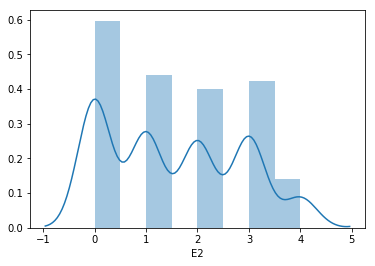

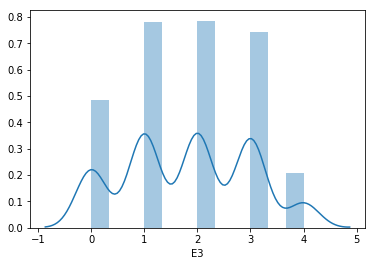

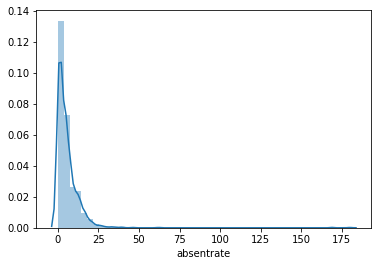

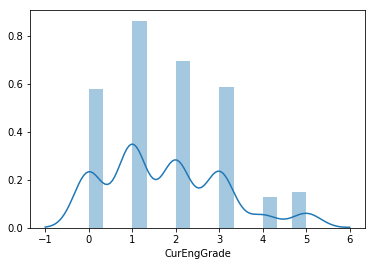

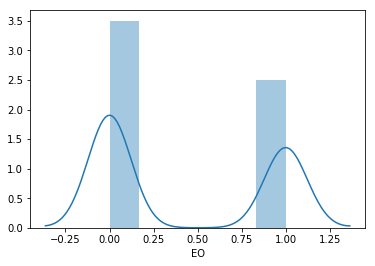

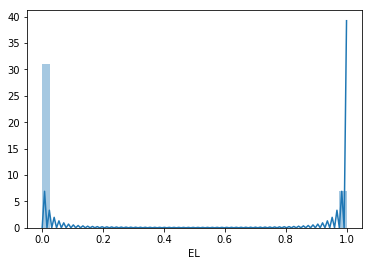

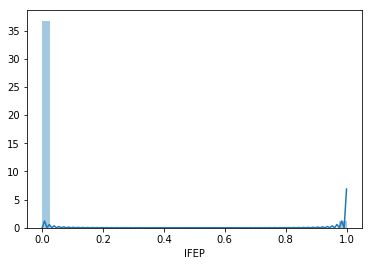

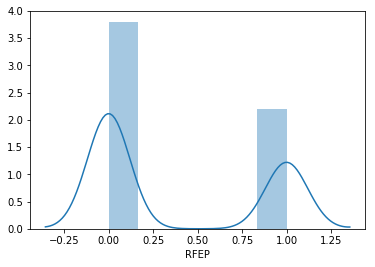

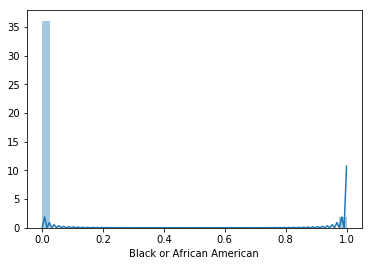

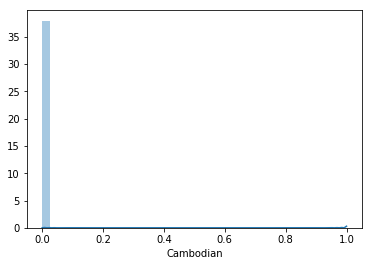

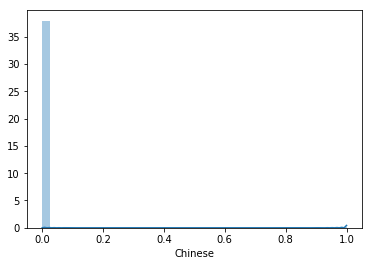

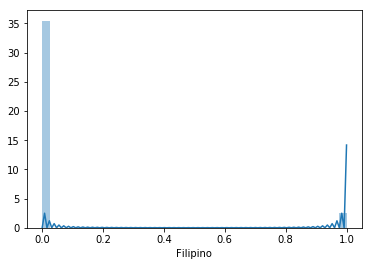

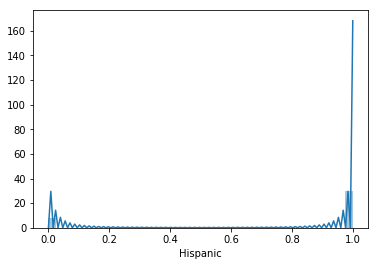

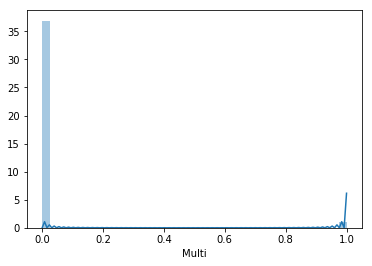

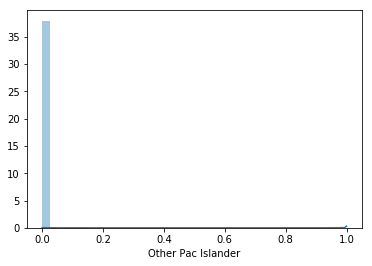

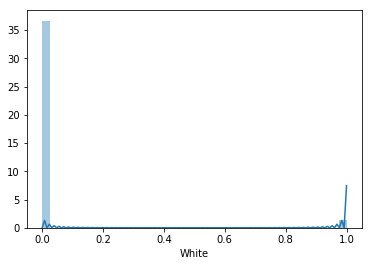

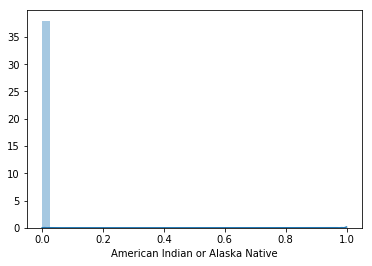

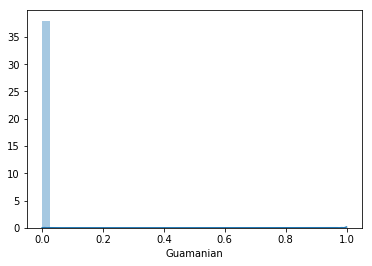

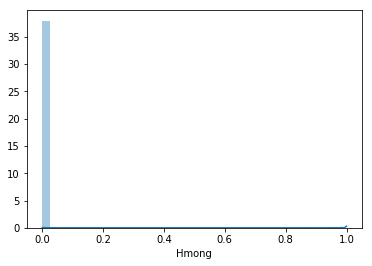

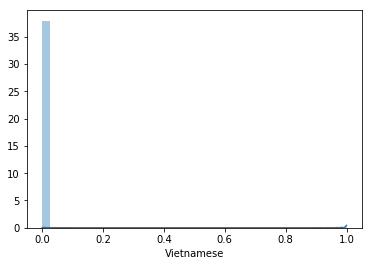

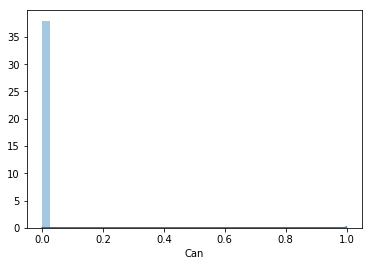

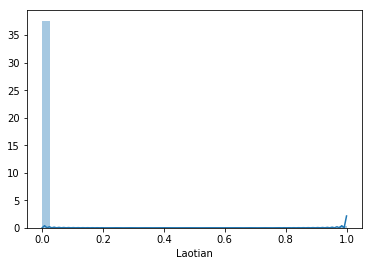

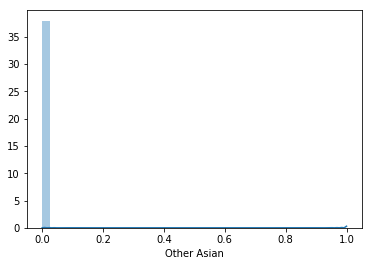

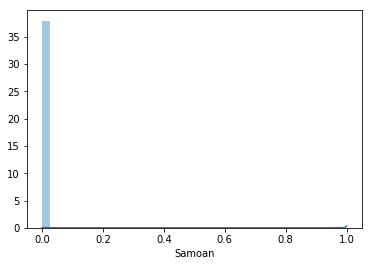

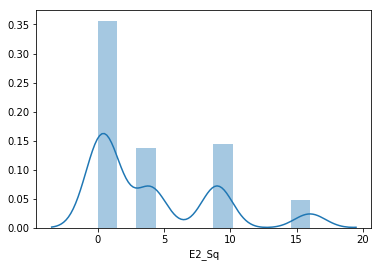

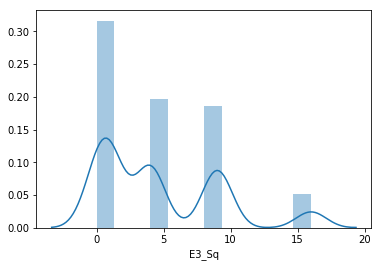

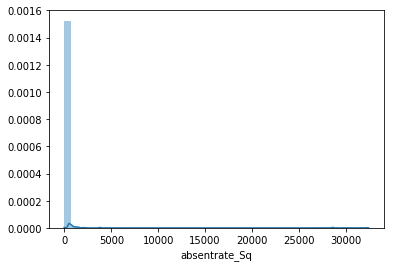

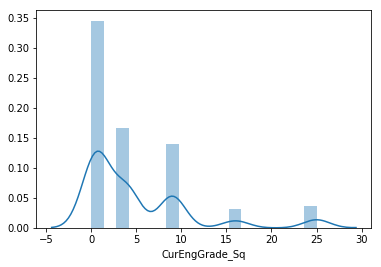

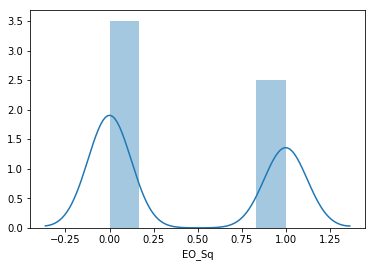

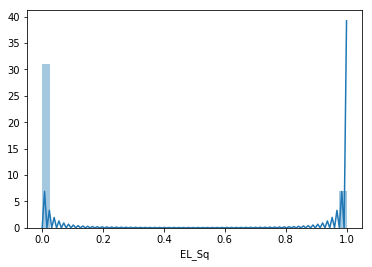

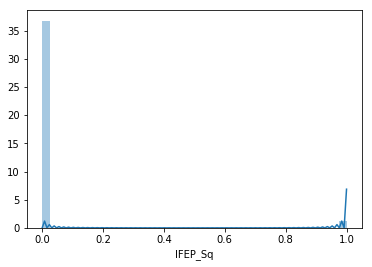

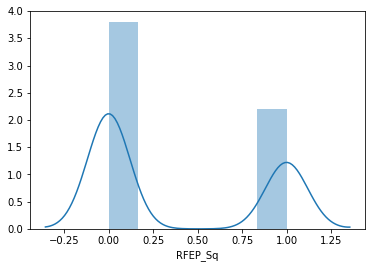

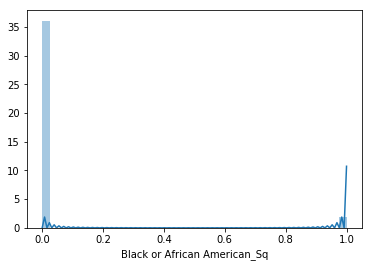

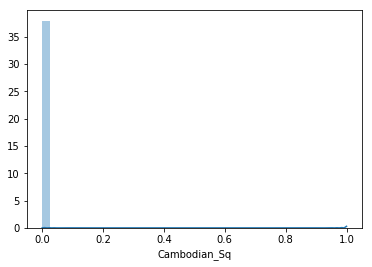

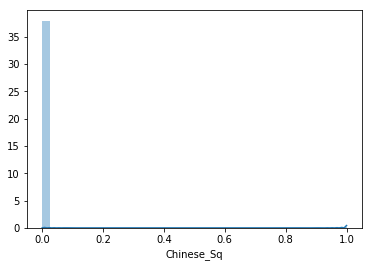

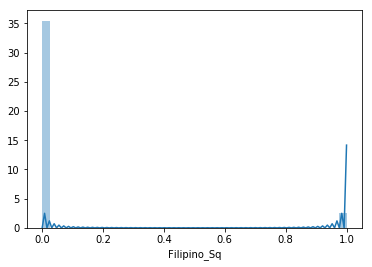

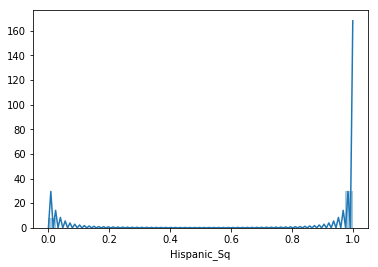

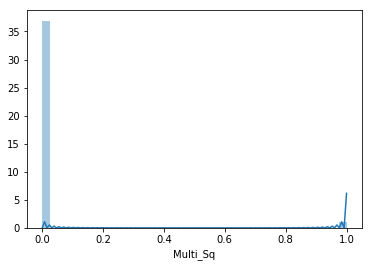

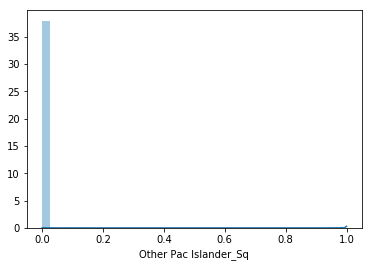

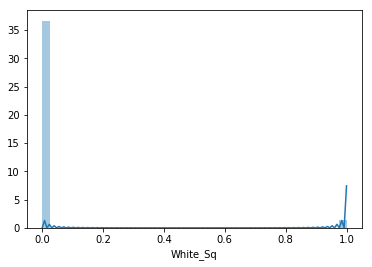

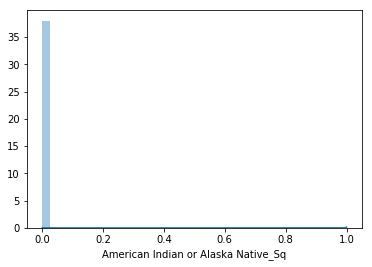

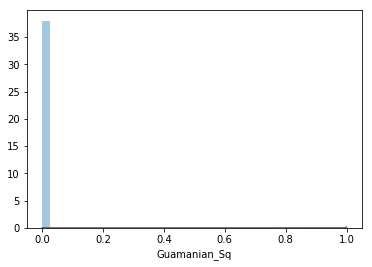

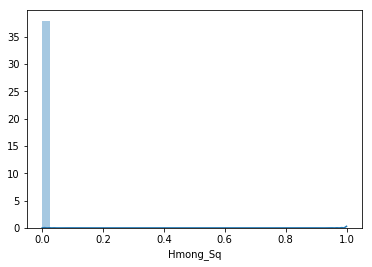

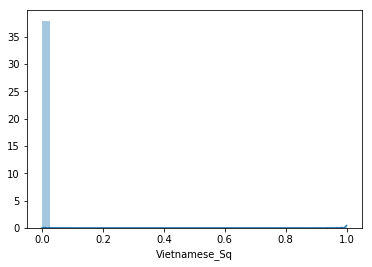

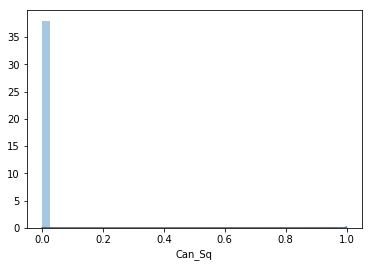

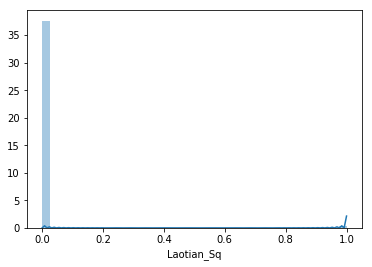

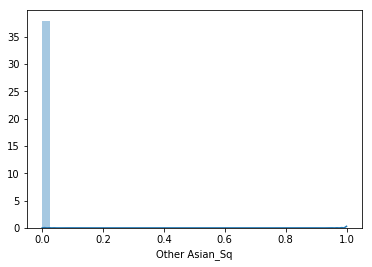

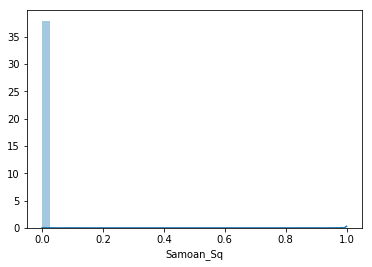

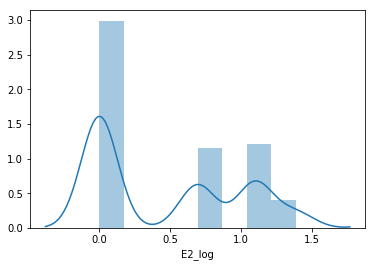

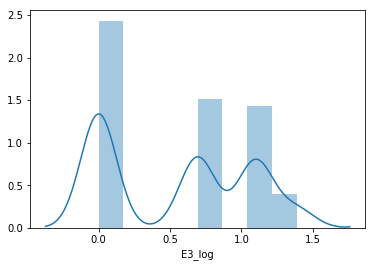

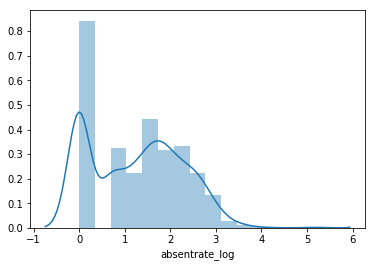

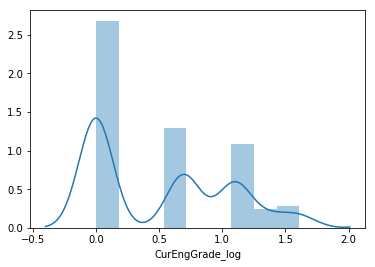

c:\users\sakok\miniconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
c:\users\sakok\miniconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


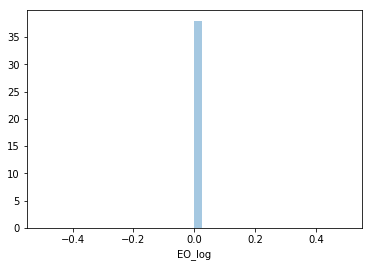

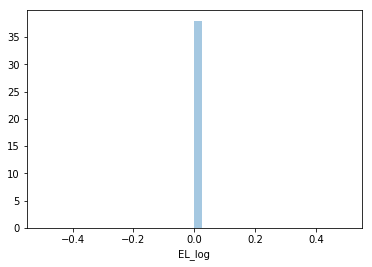

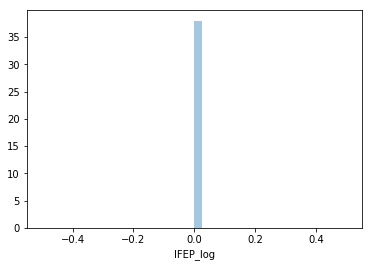

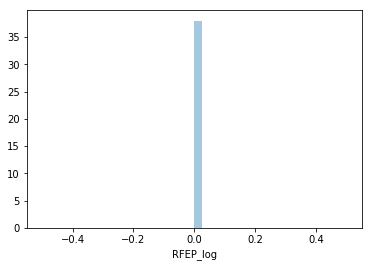

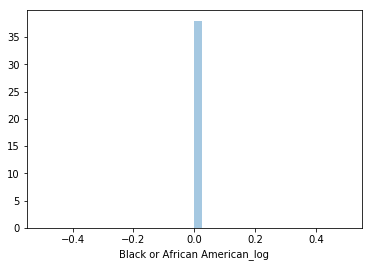

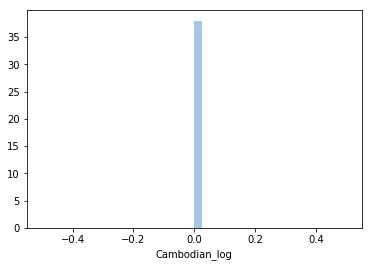

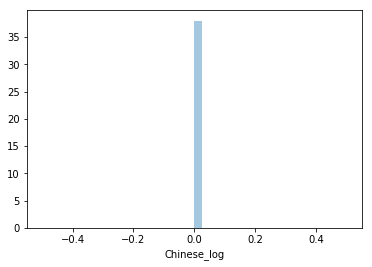

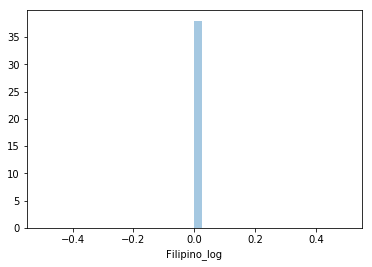

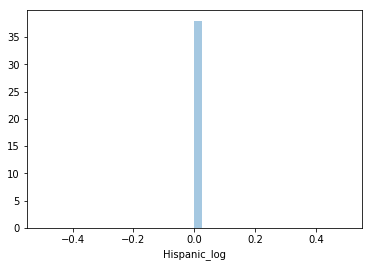

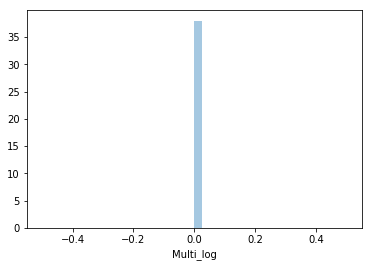

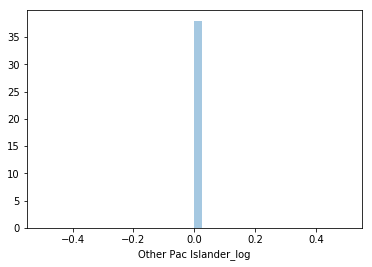

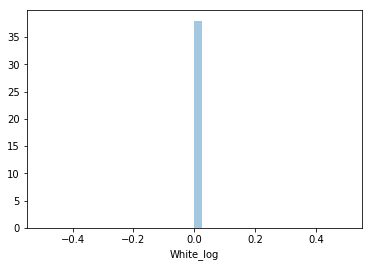

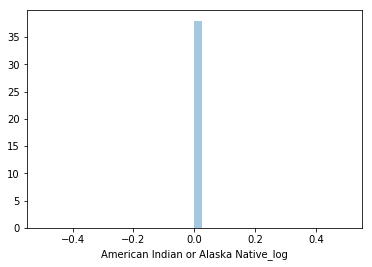

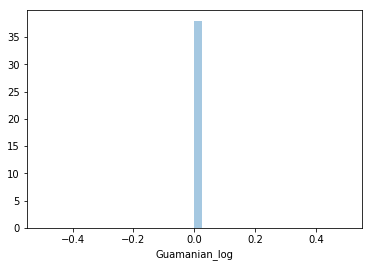

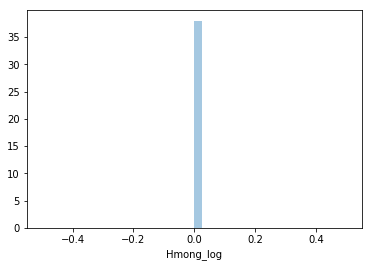

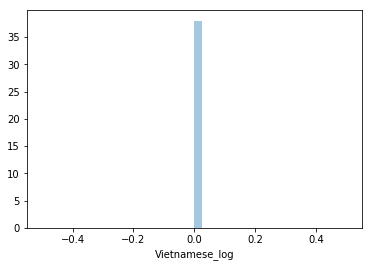

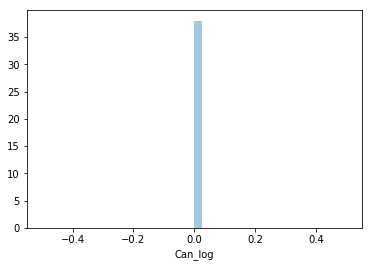

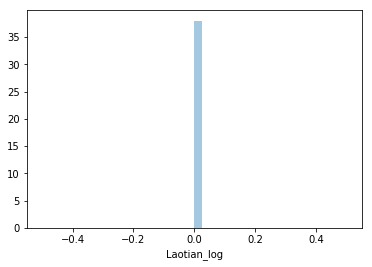

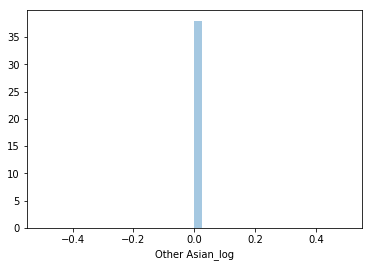

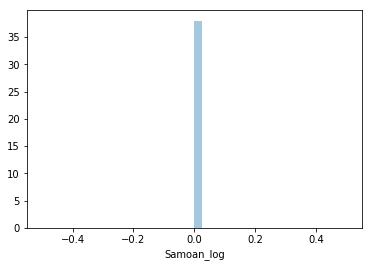

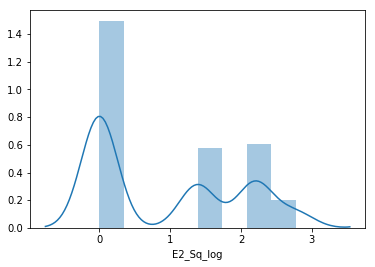

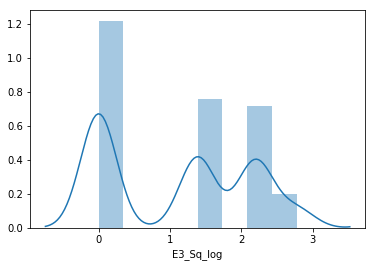

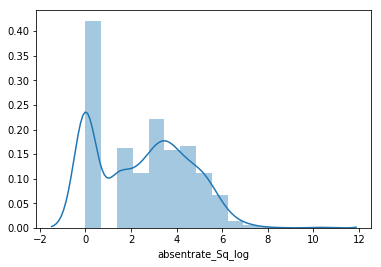

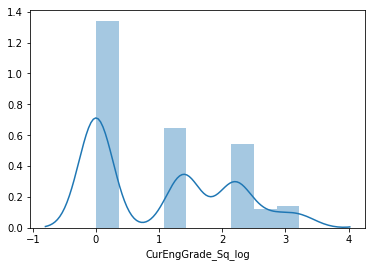

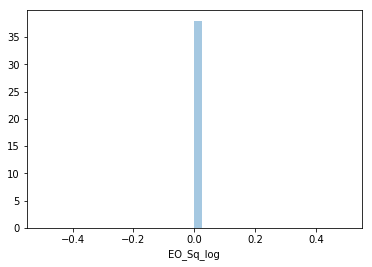

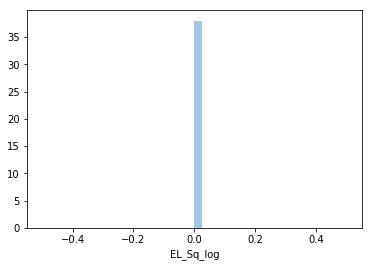

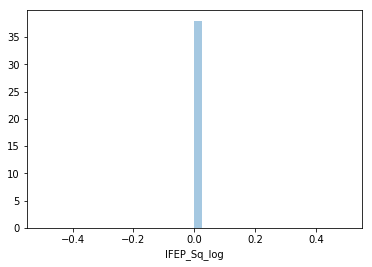

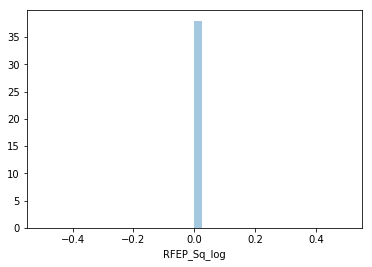

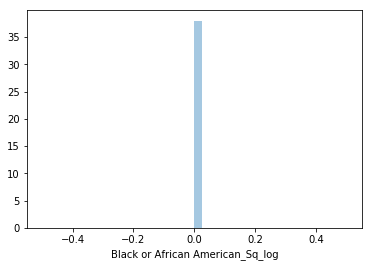

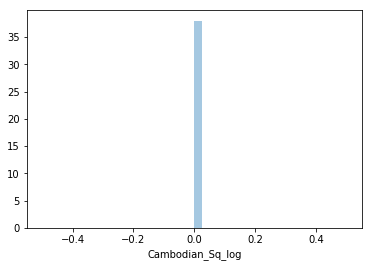

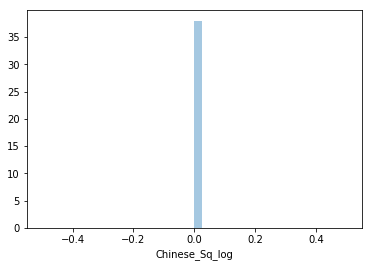

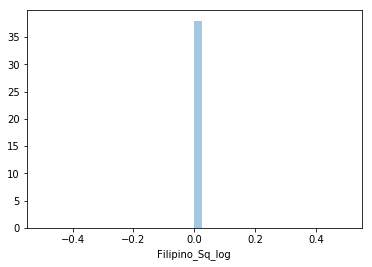

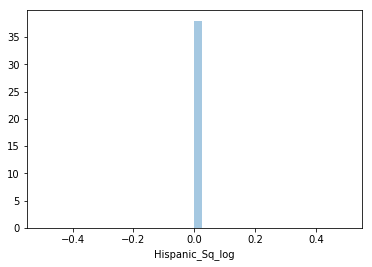

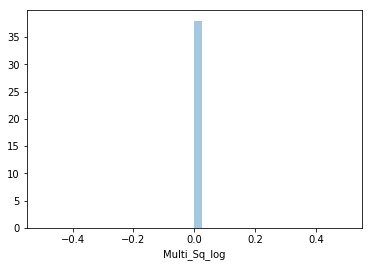

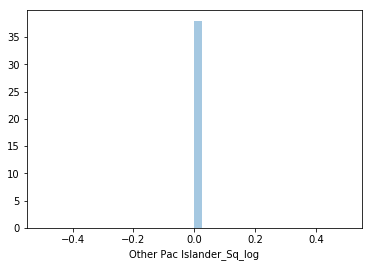

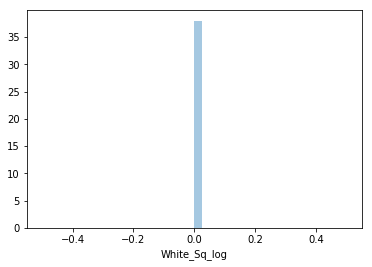

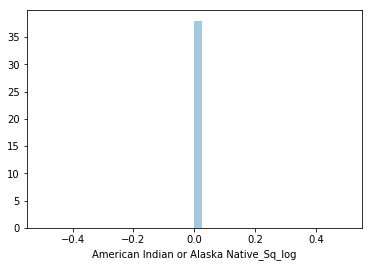

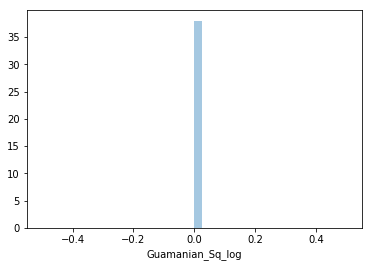

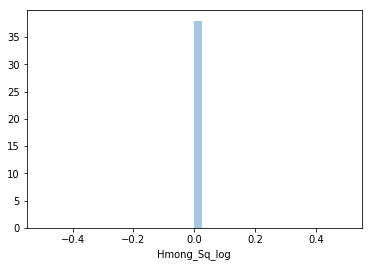

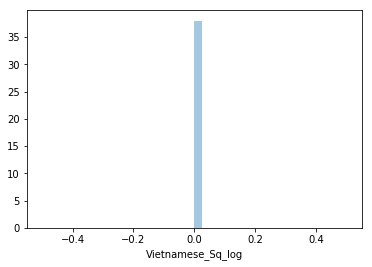

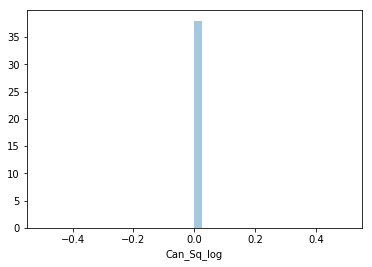

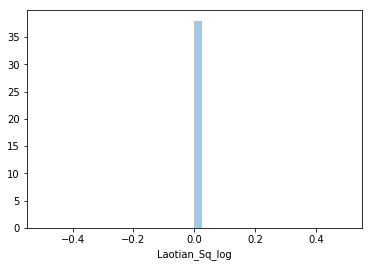

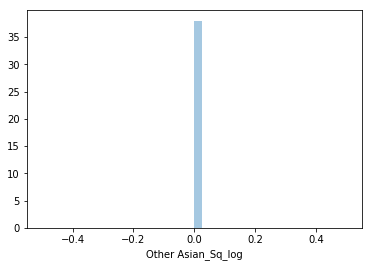

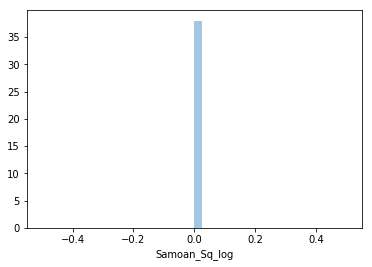

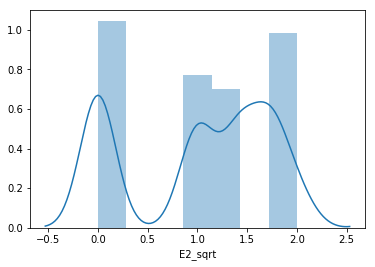

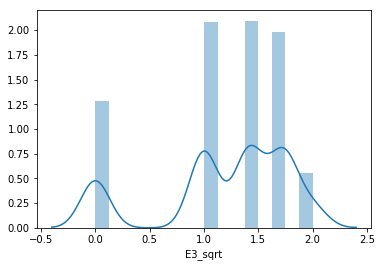

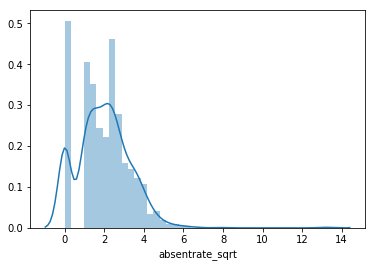

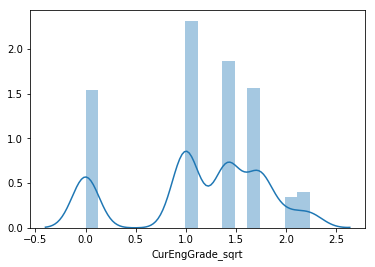

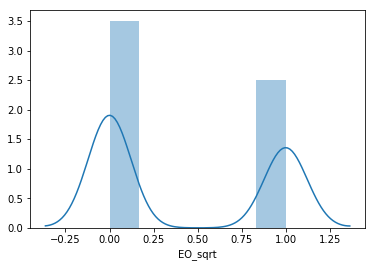

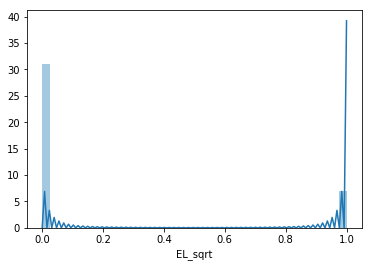

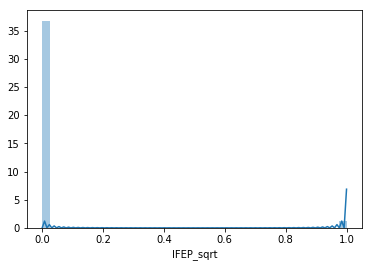

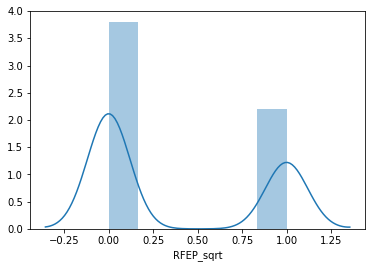

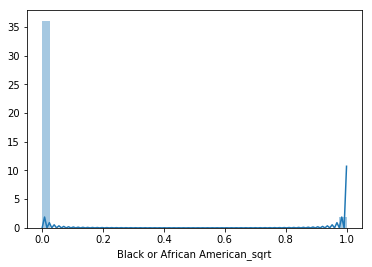

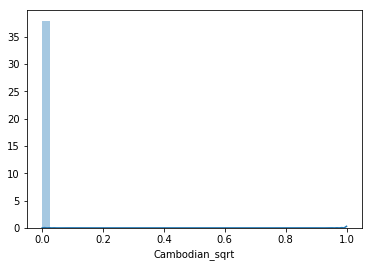

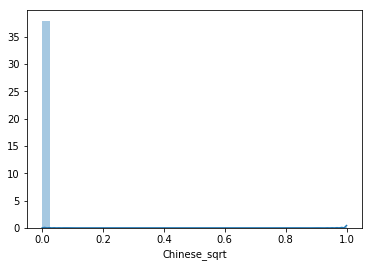

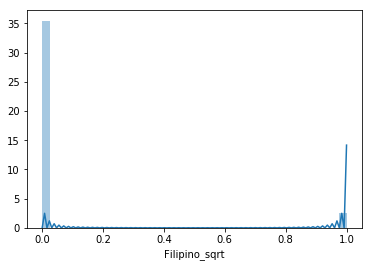

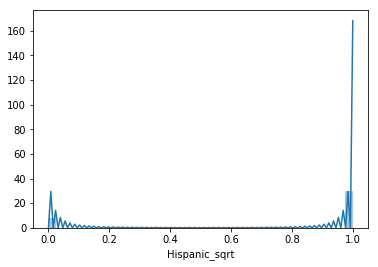

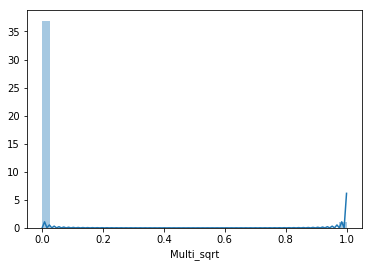

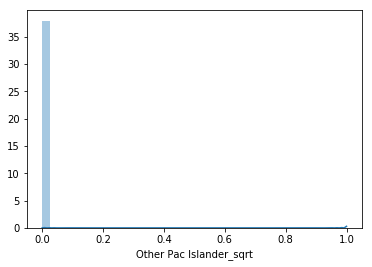

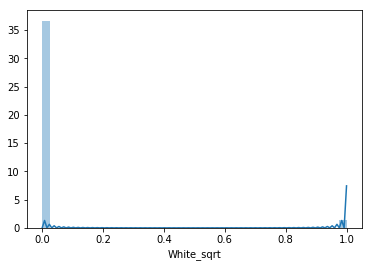

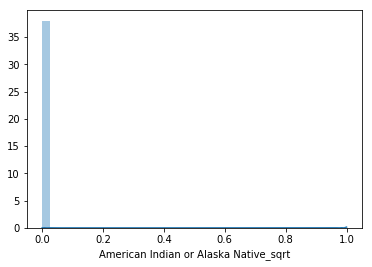

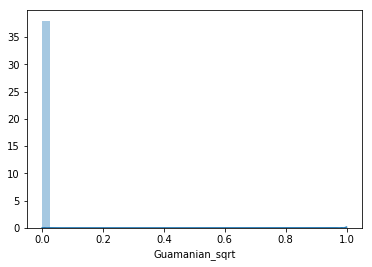

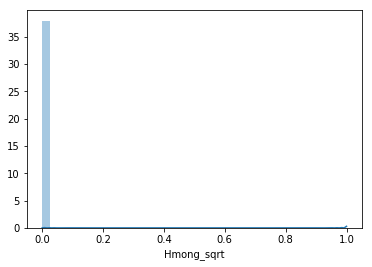

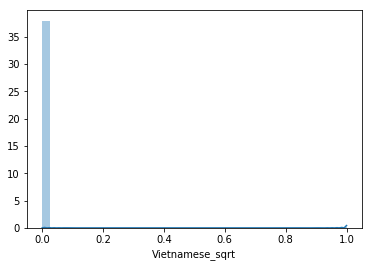

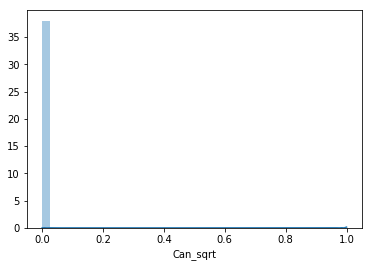

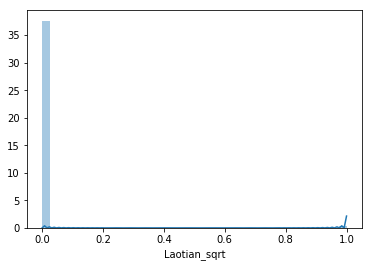

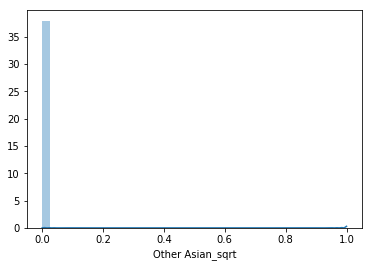

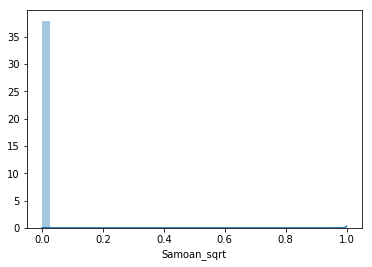

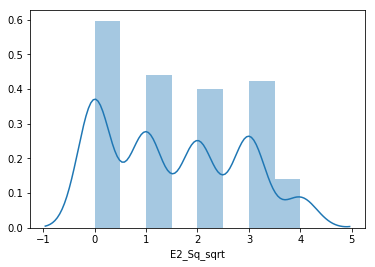

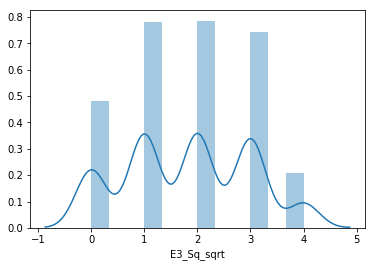

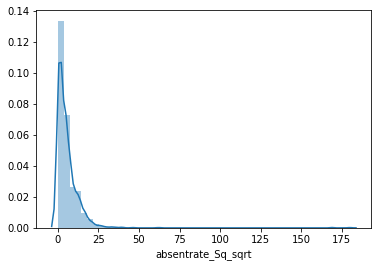

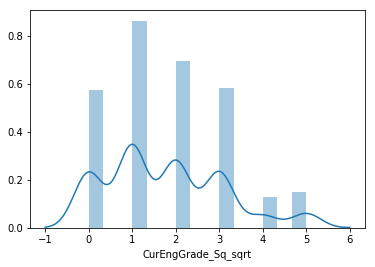

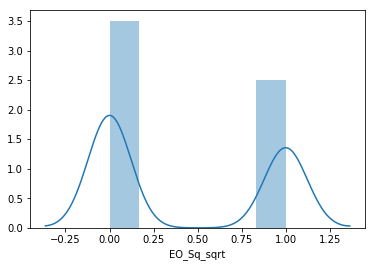

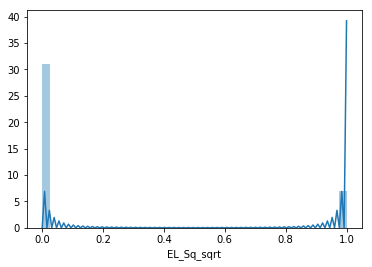

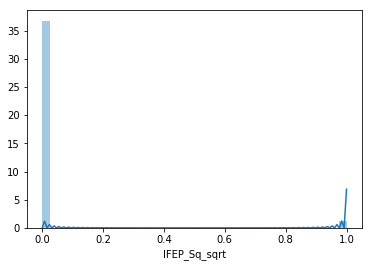

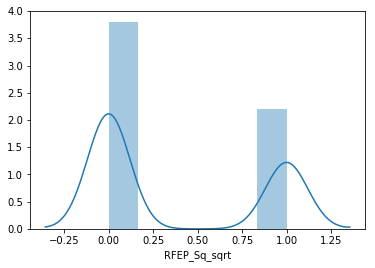

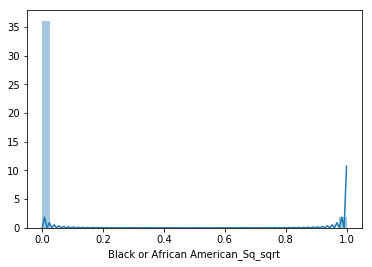

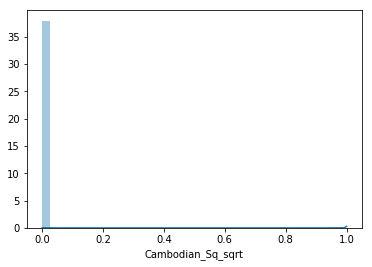

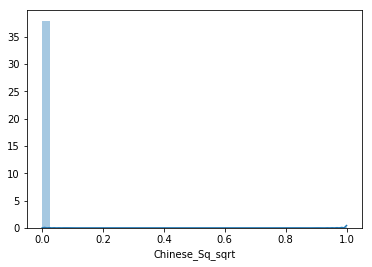

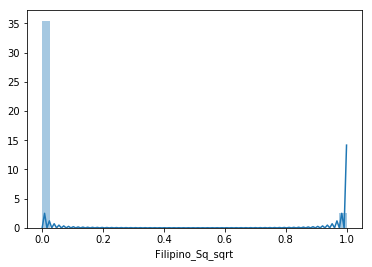

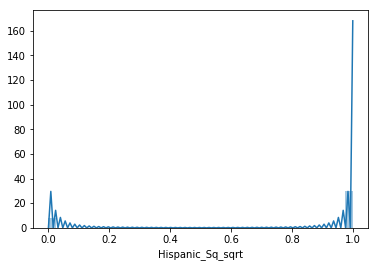

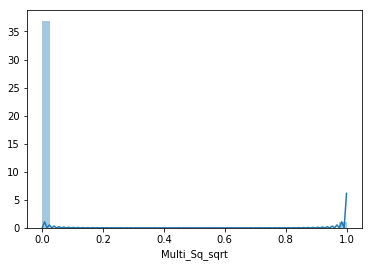

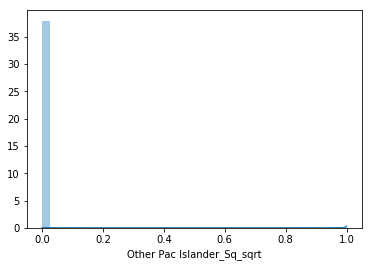

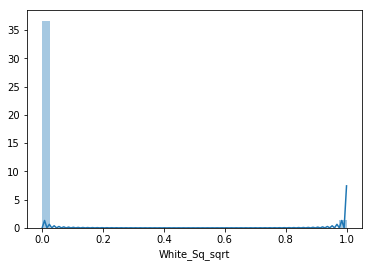

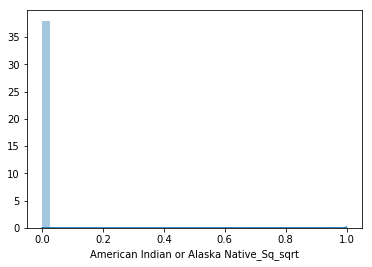

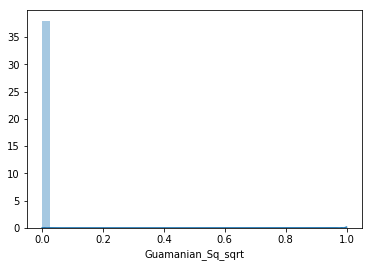

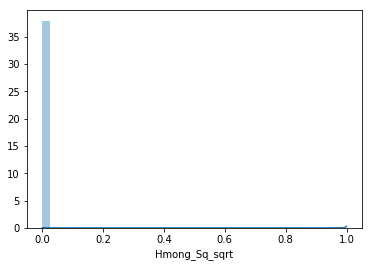

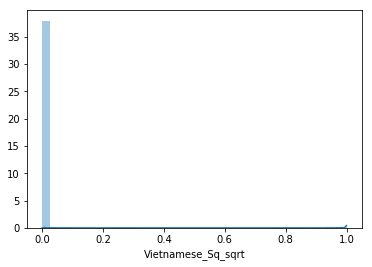

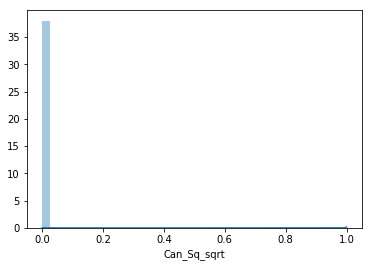

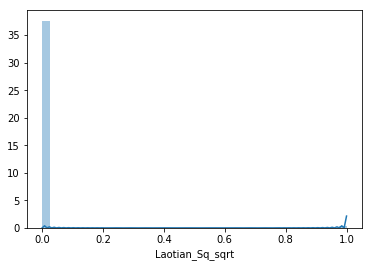

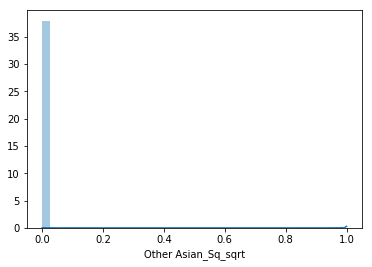

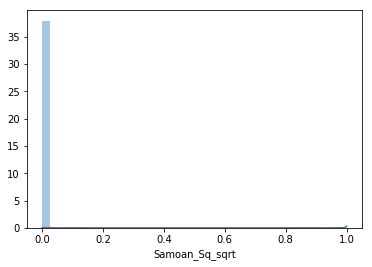

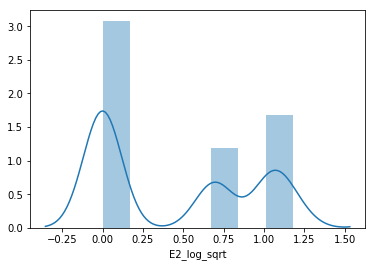

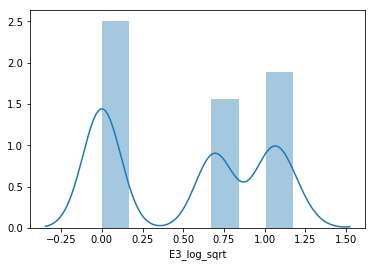

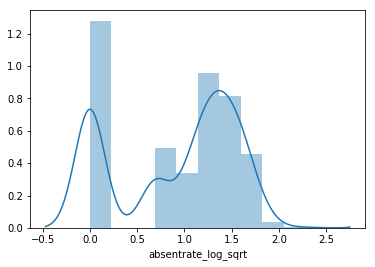

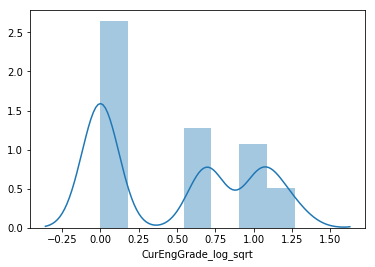

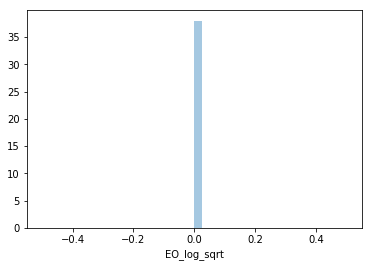

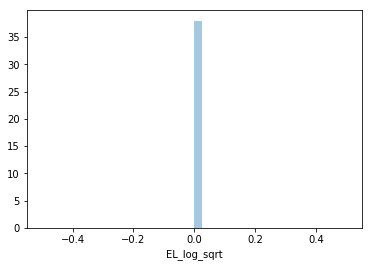

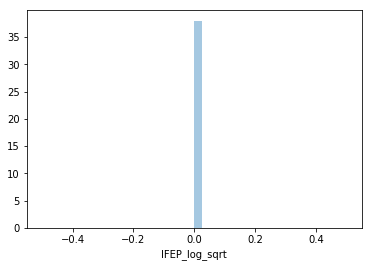

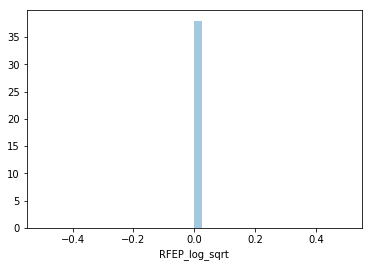

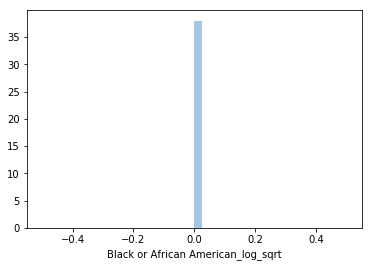

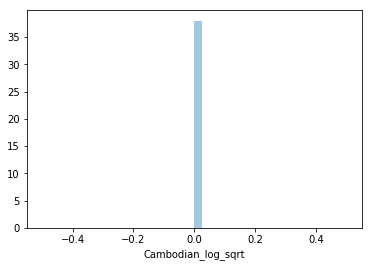

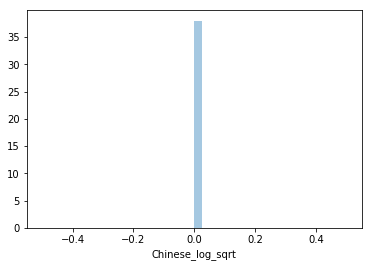

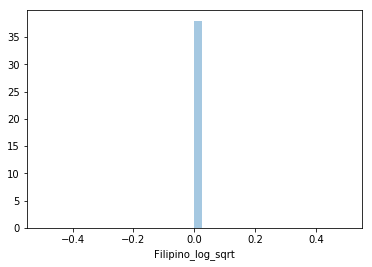

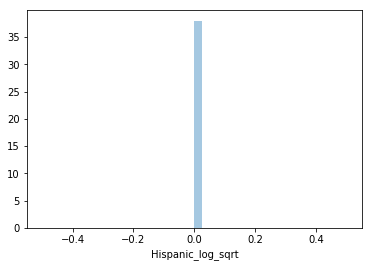

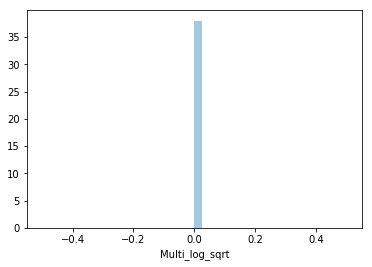

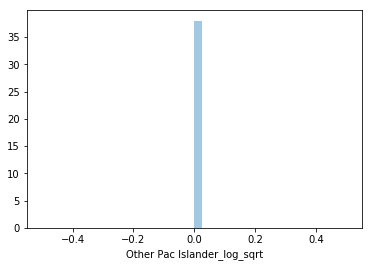

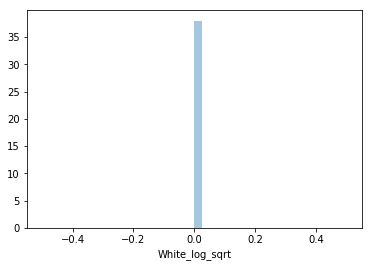

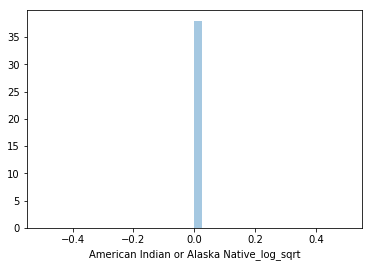

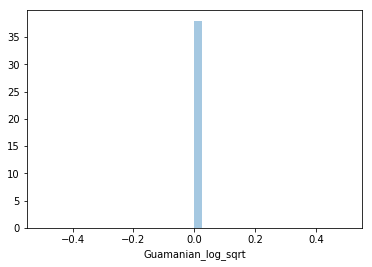

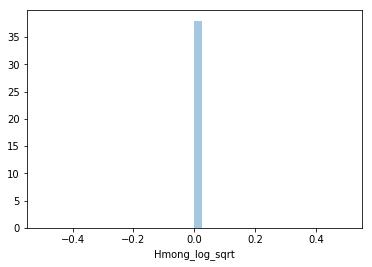

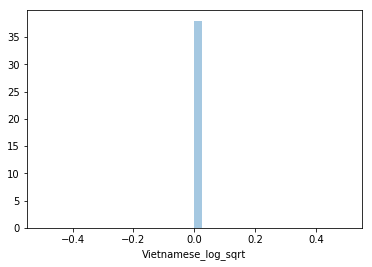

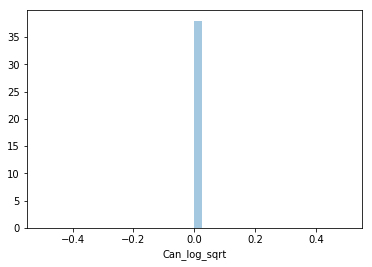

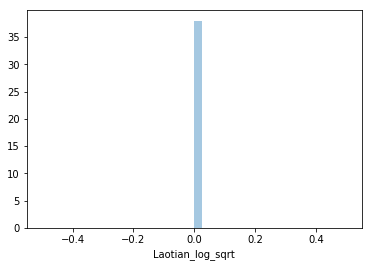

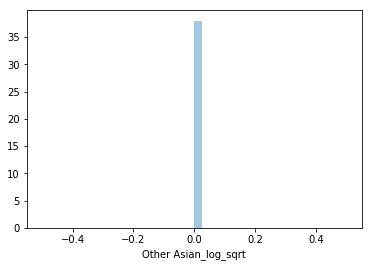

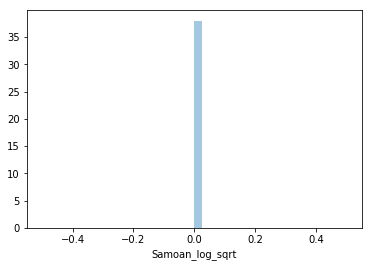

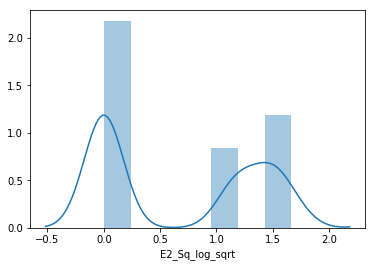

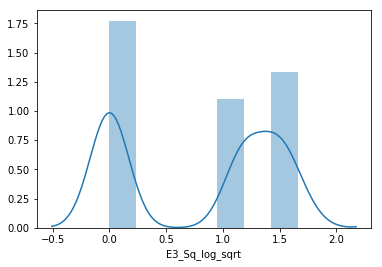

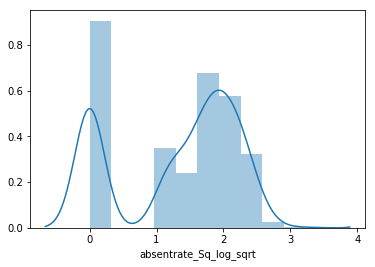

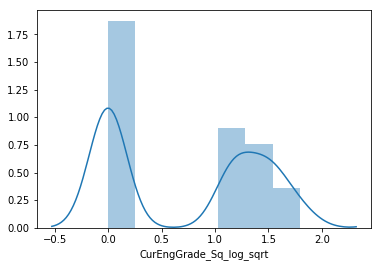

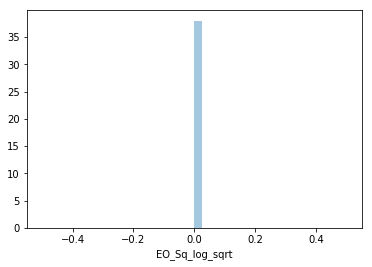

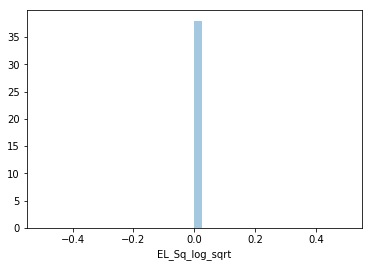

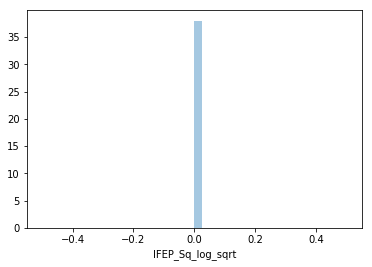

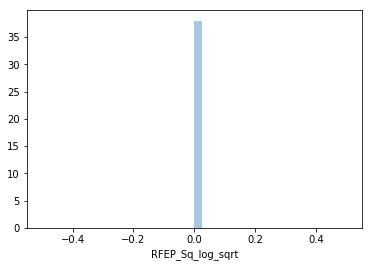

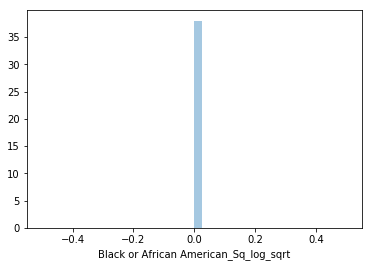

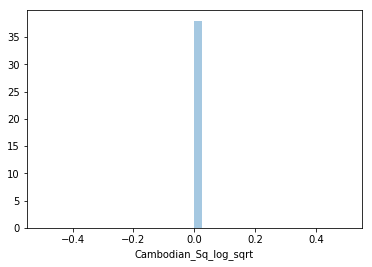

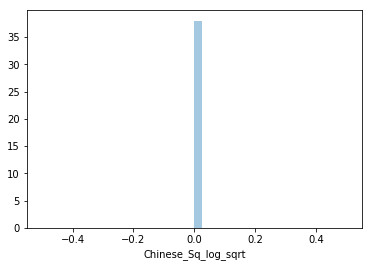

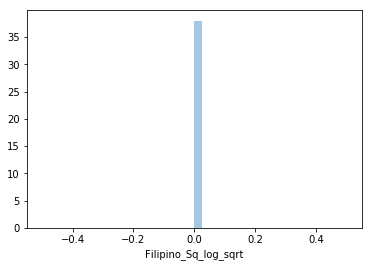

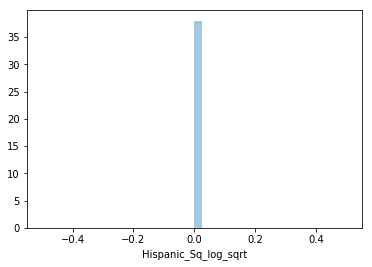

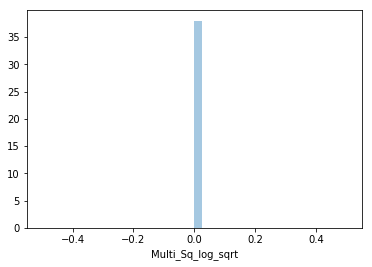

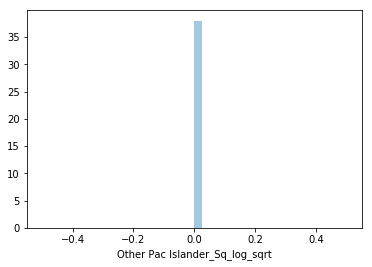

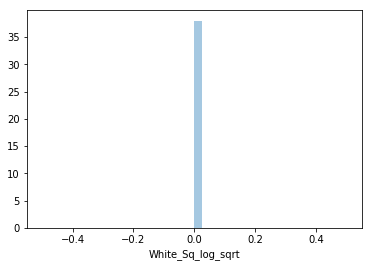

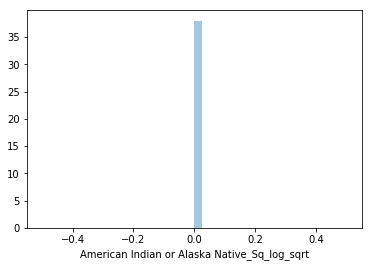

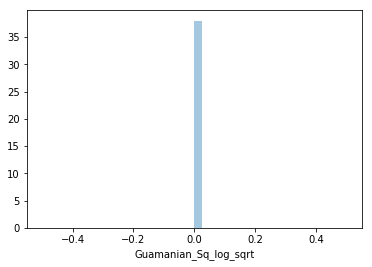

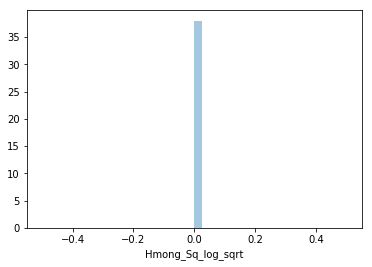

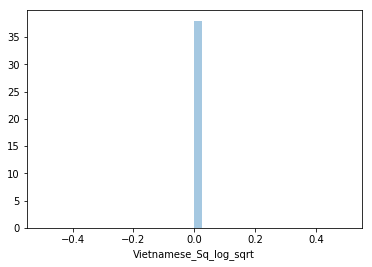

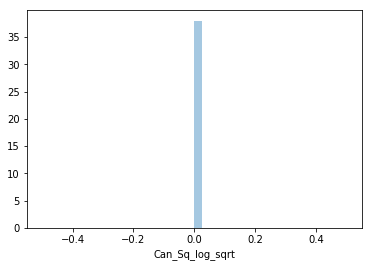

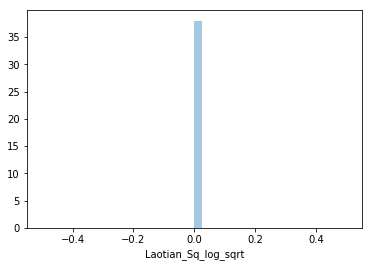

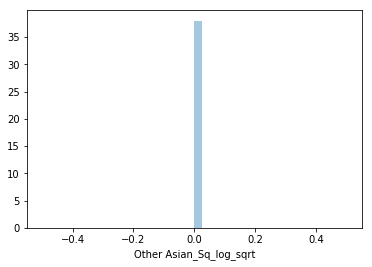

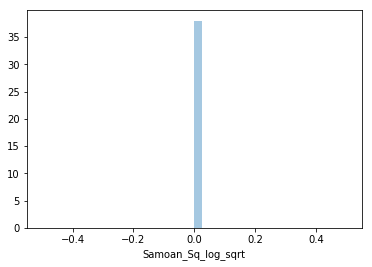

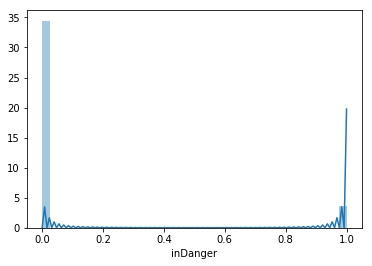

In [20]:
for x1 in X:
    sns.distplot(X[x1])
    plt.show()


In [ ]:
for x1 in X:
    sns.boxplot(x=y,y=X[x1] )
    plt.show()


In [ ]:
for x1 in X:
    print(x1)
    stats.probplot(X[x1], dist="norm", plot=pylab)
    pylab.show()

### There is a lot of categorical data
#### Some of it is due to converting the grades and ELA status to OHE

In [ ]:
#The interesting one for me is our distribution of ELA status at the bottom. 

## ELA Status of a student based on their English grades

In [ ]:
#will start with a logistic regression as this is a classification problem

In [34]:
# Declare a logistic regression classifier.
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble

#lr = ensemble.GradientBoostingClassifier(subsample=.2, n_estimators=300, max_features=2)
lr = LogisticRegression()
# Fit the model.
lr.fit(X_train, y_train)

# Display.
print('Coefficients')
print(lr.coef_)

#print(lr.intercept_)
pred_y = lr.predict(X_test)

print('\n Accuracy by E1')
print(pd.crosstab(pred_y, y_test))

print('\n Percentage accuracy')
print(lr.score(X_train, y_train))

print("Cross Val Score")
print(cross_val_score(lr,X_test,y_test,cv=10))

c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Defau

Coefficients
[[-4.92478304e-01 -1.14009065e+00  4.15108164e-02  3.85630605e-01
   2.53786642e-01  5.82836132e-01  8.99165489e-02  3.01587840e-01
   1.85820841e-01 -1.62512333e-01  1.18738833e-01  8.86427377e-02
  -7.09859460e-02  2.67018745e-01 -1.07150112e-01 -2.63057957e-01
   0.00000000e+00  0.00000000e+00  3.30101479e-02  3.03980277e-01
  -9.83531620e-02  2.64416250e-01  7.18795923e-02  5.96679250e-01
   2.39130851e-02  4.84703818e-01 -2.08192354e-04 -8.74047914e-02
   2.53786642e-01  5.82836132e-01  8.99165489e-02  3.01587840e-01
   1.85820841e-01 -1.62512333e-01  1.18738833e-01  8.86427377e-02
  -7.09859460e-02  2.67018745e-01 -1.07150112e-01 -2.63057957e-01
   0.00000000e+00  0.00000000e+00  3.30101479e-02  3.03980277e-01
  -9.83531620e-02  2.64416250e-01  7.18795923e-02  5.96679250e-01
   4.68680766e-01  3.16456873e-01 -1.81090322e-01  5.61224310e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+

c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Defau

[0.55555556 0.47169811 0.64150943 0.55769231 0.59615385 0.55769231
 0.54901961 0.47058824 0.56       0.56      ]


c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\sakok\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Defau

In [ ]:
print(metrics.classification_report(y_test,pred_y))

In [24]:
193 / 3

64.33333333333333

In [25]:
#next we will look at a random forest
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=200, max_depth=5, max_features=64 )

rfc.fit(X_train,y_train)
pred_rfc = rfc.predict(X_test)

print(rfc.score(X_train,y_train))
print('\n Accuracy by ela status')
print(pd.crosstab(pred_rfc, y_test))

cross_val_score(rfc,X_test, y_test,cv=10, n_jobs=-1)

0.6697916666666667

 Accuracy by ela status
col_0    0    1   2   3   4
row_0                      
0      104    6   0   3   6
1       29  127  54  19   3
2        0    4  12   4   1
3       17    6  21  51  14
4        6    0   1   3  27


array([0.72222222, 0.64150943, 0.67924528, 0.57692308, 0.76923077,
       0.67307692, 0.58823529, 0.54901961, 0.68      , 0.62      ])

In [ ]:
print(metrics.classification_report(y_test,pred_rfc))

In [ ]:
#Linear SVC
from sklearn.svm import LinearSVC
svc = LinearSVC(C=.5)
svc.fit(X_train, y_train)
#predictions
predsvc = svc.predict(X_test)

print(svc.score(X_train,y_train))
print('\n Accuracy by ela status')
print(pd.crosstab(predsvc, y_test))

cross_val_score(svc,X_test, y_test,cv=10)


In [ ]:
print(metrics.classification_report(y_test,predsvc))